# 

In [1]:
import sys
import datetime
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import (
    MultilabelStratifiedKFold
)
from sklearn.metrics import log_loss
from sklearn.utils.class_weight import compute_class_weight

# import PyTorch Modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler
from torch.utils.data import (
    Subset
)

# import PyTorch Modules for ComputerVision.
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as F
from torchvision.io import read_image
from torchvision.models import resnet18

sys.path.append("../src/")
plt.rcParams["savefig.bbox"] = 'tight'
plt.ion()   # interactive mode
cudnn.benchmark = True


In [2]:
# my modules for RSNA2023.
from dataset_handler import AbdominalTraumaDataset, make_datalodaers
from model import MultiAbdominalTraumaClassifier
from metric import score, add_sample_weights, make_submission_file


In [3]:
# utilities.
def torch_fix_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms = True


torch_fix_seed()


In [4]:
start_time = datetime.datetime.today().strftime("%Y%m%d%H%M")
save_dir = Path(rf"D:\RSNA2023\data\out\models\baseline\{start_time}")
save_dir.mkdir(parents=True, exist_ok=True)

num_epoch = 20
learning_rate = 1e-4
batch_size = 128
n_split = 5
random_state = 0
stride = 4
criterions_weights = {
    "bowel_injury": 1,
    "extravasation_injury": 3,
    "kidney_injury": 3,
    "liver_injury": 3,
    "spleen_injury": 3,
    "any_injury": 0.5,
    "incomplete_organ": 0.5
}
local_test_patients = -500  # Select 500 people from the back

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
train_image_root_dir = Path(
    r"D:\RSNA2023\data\train_images"
)

patient_info = pd.read_csv(
    r"D:\RSNA2023\data\train.csv"
)
patient_series = pd.read_csv(
    r"D:\RSNA2023\data\train_series_meta.csv"
)

train_patient_info = patient_info.iloc[:local_test_patients, :].copy()
train_patient_series = patient_series.query(
    "patient_id in @train_patient_info.patient_id.values"
)

test_patient_info = patient_info.iloc[local_test_patients:, :].copy()
test_patient_series = patient_series.query(
    "patient_id in @test_patient_info.patient_id.values"
)


In [6]:
# calc class weights..
data = patient_series.merge(patient_info)
data["kidney_injury"] = data["kidney_low"] + (data["kidney_high"] * 2)
data["liver_injury"] = data["liver_low"] + (data["liver_high"] * 2)
data["spleen_injury"] = data["spleen_low"] + (data["spleen_high"] * 2)

target_labels = [
    "bowel_injury",
    "extravasation_injury",
    "kidney_injury",
    "liver_injury",
    "spleen_injury",
    "any_injury",
    "incomplete_organ",
]

class_weights = {}
for label in target_labels:
    class_weights[label] = torch.from_numpy(compute_class_weight(
        class_weight="balanced",
        classes=np.sort(data.loc[:, label].unique()),
        y=data.loc[:, label].values
    ).astype(np.float32))
    print(
        f"{label} weights: " +
        ", ".join(str(_.item()) for _ in class_weights[label])
    )


bowel_injury weights: 0.5112871527671814, 22.649038314819336
extravasation_injury weights: 0.534005880355835, 7.851666450500488
kidney_injury weights: 0.3547974228858948, 8.922348022460938, 14.40672779083252
liver_injury weights: 0.3707113564014435, 4.089409828186035, 17.256410598754883
spleen_injury weights: 0.3769403100013733, 4.969409465789795, 6.857350826263428
any_injury weights: 0.6881390810012817, 1.82880437374115
incomplete_organ weights: 0.5355843305587769, 7.525558948516846


[Epoch: 20/20, Phase: valid]: 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


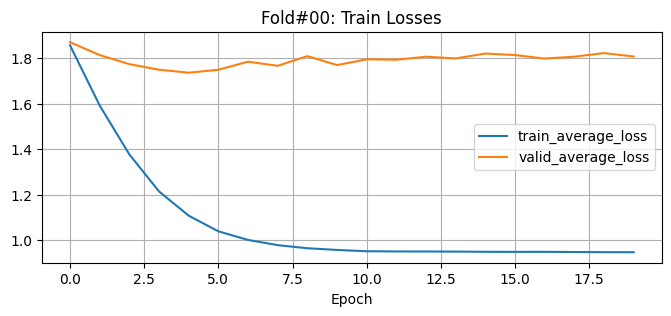

[Epoch: 20/20, Phase: valid]: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


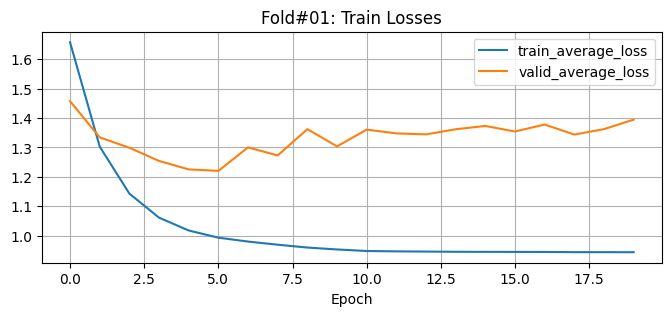

[Epoch: 20/20, Phase: valid]: 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


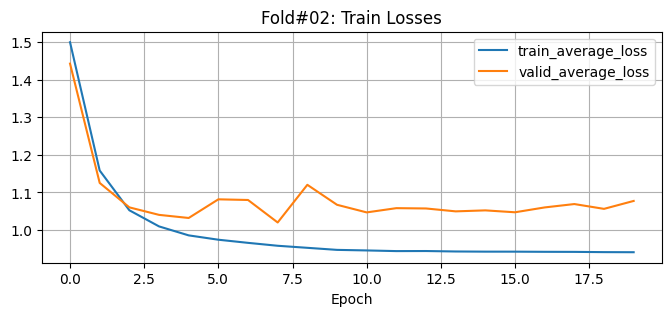

[Epoch: 20/20, Phase: valid]: 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


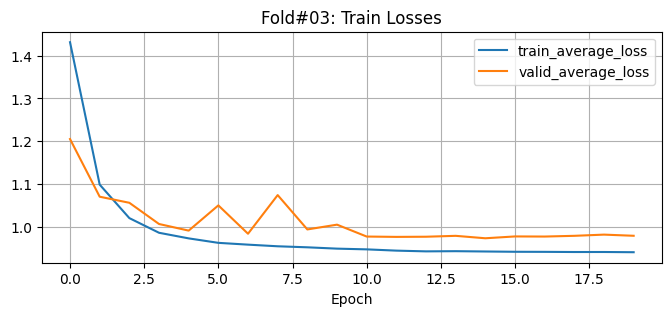

[Epoch: 20/20, Phase: valid]: 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


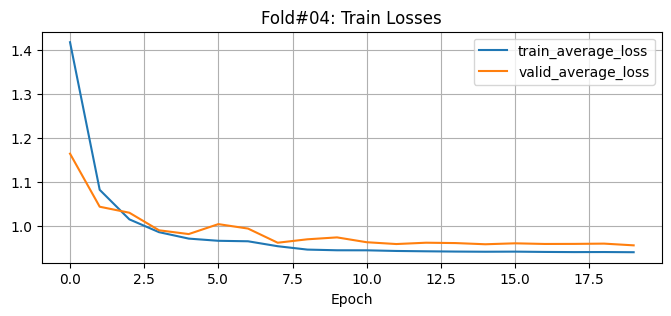

In [8]:
# Make dataset for RSNA2023 AbdominalTrauma.
dataset = AbdominalTraumaDataset(
    train_patient_info,
    train_patient_series,
    train_image_root_dir,
    img_extension=".png",
    has_pseudo3D_img=True,
    stride=stride
)

# dataset split by multilabel stratified split.
data_spliter = MultilabelStratifiedKFold(
    n_splits=n_split,
    shuffle=True,
    random_state=random_state,
)

# baseline model trained by 1fold.
train_indices, valid_indices = next(
    data_spliter.split(dataset.labels, dataset.labels)
)

for k, (train_indices, valid_indices) in enumerate(data_spliter.split(dataset.labels, dataset.labels)):
    save_sub_dir = save_dir / f"fold#{k:02}"
    save_sub_dir.mkdir(parents=True, exist_ok=True)

    train_dataset = Subset(dataset, train_indices)
    train_dataset.dataset.transform = nn.Sequential(
        transforms.Resize((224, 224), antialias=True),
        transforms.RandomAdjustSharpness(1.80, p=0.5),
        transforms.RandomErasing(p=0.5, scale=(0.001, 0.005), ratio=(1, 1)),
        transforms.ConvertDtype(),
        transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
    )

    valid_dataset = Subset(dataset, valid_indices)
    valid_dataset.dataset.transform = nn.Sequential(
        transforms.Resize((224, 224), antialias=True),
        transforms.ConvertDtype(),
        transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
    )
    dataloaders = make_datalodaers(
        train_dataset,
        valid_dataset,
        batch_size=batch_size
    )

    model = MultiAbdominalTraumaClassifier()
    criterions = {
        classname: nn.CrossEntropyLoss(weight=weights.to(device))
        for classname, weights in class_weights.items()
    }

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    history = model.fit(
        dataloaders,
        criterions,
        optimizer,
        exp_lr_scheduler,
        num_epoch,
        save_dir=save_sub_dir, 
        criterions_weight=criterions_weights
    )

    train_history = pd.DataFrame(history).T
    train_history.to_csv(save_sub_dir / "history.csv")

    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    ax.set_title(f"Fold#{k:02}: Train Losses")
    ax.set_xlabel("Epoch")
    train_history.loc[:, ["train_average_loss",
                          "valid_average_loss"]].plot(ax=ax)
    ax.grid()

    plt.close()
    display(fig)


# 📝 Score

In [96]:
def mean_ensemble(predicts:list[pd.DataFrame]):
    
    for i, p in enumerate(predicts):
        if i == 0:
            pred_mean = p.copy()
        else:
            pred_mean.iloc[:, 1:] += p.iloc[:, 1:]
        
    pred_mean.iloc[:, 1:] = pred_mean.iloc[:, 1:] / len(predicts)
    
    return pred_mean


In [97]:
models = []
for k in range(n_split):
    save_sub_dir = save_dir / f"fold#{k:02}"

    weighted_cols = [
        "valid_extravasation_injury",
        "valid_kidney_injury",
        "valid_liver_injury",
        "valid_spleen_injury"
    ]
    
    history = pd.read_csv(save_sub_dir / "history.csv")
    history[weighted_cols] = history[weighted_cols] * 3
    best_epoch = history.loc[:, [
        "valid_bowel_injury",
        "valid_extravasation_injury",
        "valid_kidney_injury",
        "valid_liver_injury",
        "valid_spleen_injury",
    ]].mean(axis=1).idxmin()
    
    model = MultiAbdominalTraumaClassifier()
    model.load_model_state(save_sub_dir / f"E{best_epoch:03}.pt", device)
    print(f"fold#{k:02}'s best epoch: E{best_epoch:03}")
    models.append(model)


fold#00's best epoch: E004
fold#01's best epoch: E005
fold#02's best epoch: E007
fold#03's best epoch: E014
fold#04's best epoch: E019


In [98]:
test_dataset = AbdominalTraumaDataset(
    test_patient_info,
    test_patient_series,
    train_image_root_dir,
    img_extension=".png",
    transform=nn.Sequential(
        transforms.Resize((224, 224), antialias=True),
        transforms.ConvertDtype(),
        transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
    ),
    has_pseudo3D_img=True
)


In [99]:
scores, preds = [], []
for model in models:
    pred_test_series = model.predict(test_dataset)
    y_pred = make_submission_file(
        pred_test_series, test_patient_series.reset_index(drop=True))
    preds.append(y_pred.copy())
    y_true = add_sample_weights(test_patient_info)
    scores.append(score(y_true.copy(), y_pred.copy(), "patient_id"))

scores = pd.DataFrame(
    scores, columns=["bowel", "extravasation", "kidney", "liver", "spleen", "any"])
scores["Average"] = scores.mean(axis=1)
scores.loc["CV-Average"] = scores.mean(axis=0)

# -- Mean Ensemble -- #
y_pred_mean = mean_ensemble(preds)
y_true = add_sample_weights(test_patient_info)
ensemble_score = pd.Series(
    score(y_true.copy(), y_pred_mean.copy(), "patient_id"),
    index=["bowel", "extravasation", "kidney", "liver", "spleen", "any"],
)
ensemble_score["Average"] = ensemble_score.mean()
scores.loc["MeanEnsemble"] = ensemble_score

scores.to_csv(save_dir / "CV.csv")
display(scores)


100%|██████████| 743/743 [00:04<00:00, 157.26it/s]


,bowel,extravasation,kidney,liver,spleen,any,Average
0,0.214886,0.782038,0.452836,0.680176,0.903255,1.087523,0.686786
1,0.198940,0.883133,0.429324,0.664333,1.027641,1.506371,0.784957
2,0.198622,0.912132,0.459702,0.706840,1.046467,1.587947,0.818618
3,0.204835,0.998741,0.468746,0.711715,0.998092,1.578653,0.826797
4,0.208672,1.139640,0.557901,0.766412,1.110209,1.603072,0.897651
CV-Average,0.205191,0.943137,0.473702,0.705895,1.017133,1.472713,0.802962
MeanEnsemble,0.195156,0.882826,0.440371,0.635475,0.909449,1.347645,0.735154


In [100]:
scores, preds = [], []
for model in models:
    pred_test_series = model.predict(test_dataset)
    y_pred = make_submission_file(
        pred_test_series, test_patient_series.reset_index(drop=True), False, True)
    preds.append(y_pred.copy())
    y_true = add_sample_weights(test_patient_info)
    scores.append(score(y_true.copy(), y_pred.copy(), "patient_id"))

scores = pd.DataFrame(
    scores, columns=["bowel", "extravasation", "kidney", "liver", "spleen", "any"])
scores["Average"] = scores.mean(axis=1)
scores.loc["CV-Average"] = scores.mean(axis=0)

# -- Mean Ensemble -- #
y_pred_mean = mean_ensemble(preds)
y_true = add_sample_weights(test_patient_info)
ensemble_score = pd.Series(
    score(y_true.copy(), y_pred_mean.copy(), "patient_id"),
    index=["bowel", "extravasation", "kidney", "liver", "spleen", "any"],
)
ensemble_score["Average"] = ensemble_score.mean()
scores.loc["MeanEnsemble"] = ensemble_score

scores.to_csv(save_dir / "CV_weighted.csv")
display(scores)


100%|██████████| 743/743 [00:04<00:00, 178.59it/s]


,bowel,extravasation,kidney,liver,spleen,any,Average
0,0.261601,0.646240,0.559716,0.783319,0.929220,0.775568,0.659277
1,0.197915,0.663057,0.462610,0.659653,0.839257,0.996913,0.636568
2,0.207829,0.646987,0.436811,0.663920,0.855756,1.017701,0.638167
3,0.194473,0.689839,0.442618,0.616602,0.803361,1.016067,0.627160
4,0.188787,0.796484,0.499573,0.682136,0.922821,1.117876,0.701280
CV-Average,0.210121,0.688521,0.480265,0.681126,0.870083,0.984825,0.652490
MeanEnsemble,0.200492,0.633960,0.450422,0.616685,0.771701,0.877638,0.591816
